In [1]:
from IPython.display import display, Markdown
import geopandas as gpd
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import matplotlib.colors as colors

In [2]:
warnings.filterwarnings("ignore")

In [3]:
conn = sqlite3.connect('map.sqlite')
# conn.enable_load_extension(True)
# conn.load_extension('mod_spatialite')

# Application Geospatial Analysis

## View geodataframe and plot gadm_ph

In [4]:
ph_shape = gpd.read_postgis('''
SELECT 
    *
FROM gadm_ph
''', con=conn, geom_col='GEOMETRY')
ph_shape.head(4)

,ogc_fid,GEOMETRY,gid_3,gid_0,country,gid_1,name_1,nl_name_1,gid_2,name_2,nl_name_2,name_3,varname_3,nl_name_3,type_3,engtype_3,cc_3,hasc_3
0,1,"POLYGON ((120.62390 17.57298, 120.62534 17.573...",PHL.1.1.1_1,PHL,Philippines,PHL.1_1,Abra,NA,PHL.1.1_1,Bangued,NA,Agtangao,NA,NA,Barangay,Village,NA,NA
1,2,"POLYGON ((120.63432 17.58044, 120.63396 17.579...",PHL.1.1.2_1,PHL,Philippines,PHL.1_1,Abra,NA,PHL.1.1_1,Bangued,NA,Angad,NA,NA,Barangay,Village,NA,NA
2,3,"POLYGON ((120.59626 17.61632, 120.59573 17.605...",PHL.1.1.3_1,PHL,Philippines,PHL.1_1,Abra,NA,PHL.1.1_1,Bangued,NA,Banacao,NA,NA,Barangay,Village,NA,NA
3,4,"POLYGON ((120.59573 17.60569, 120.59626 17.616...",PHL.1.1.4_1,PHL,Philippines,PHL.1_1,Abra,NA,PHL.1.1_1,Bangued,NA,Bangbangar,NA,NA,Barangay,Village,NA,NA


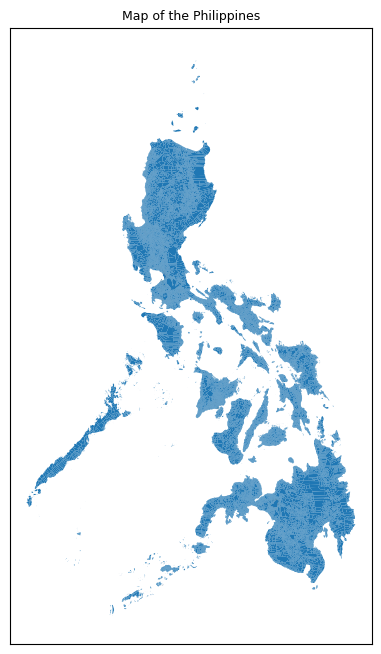

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ph_shape.plot(ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Map of the Philippines', fontsize=9)
fig.show()

## Plot NCR only (Metropolitan Manila)

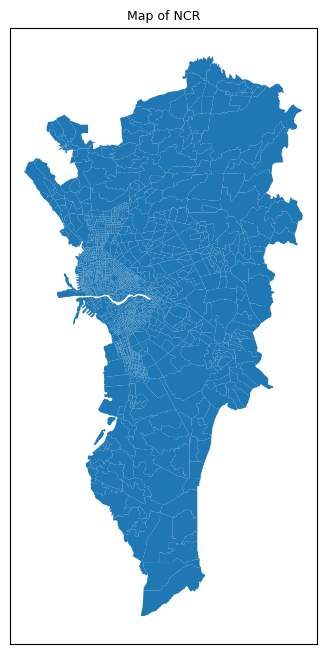

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ph_shape[ph_shape['name_1'] == 'Metropolitan Manila'].plot(ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Map of NCR', fontsize=9)
fig.show()

## Questions to Plot using geopandas
- The locations of Jollibee and Mcdonals establishments
- Preference per NCR (Metropolitan Manila) cities

In [7]:
osm_df = gpd.read_postgis('''
SELECT 
    *
FROM osm_ph_pts
''', con=conn, geom_col='GEOMETRY')
osm_df.head()

,ogc_fid,GEOMETRY,name,name_en,amenity,man_made,shop,tourism,opening_ho,beds,rooms,addr_full,addr_house,addr_stree,addr_city,source,name_fil,osm_id,osm_type
0,1,POINT (123.28010 12.22461),None,None,ferry_terminal,None,None,None,None,None,None,None,None,None,None,None,None,8340552790,nodes
1,2,POINT (123.28357 12.22478),Palawan Express,None,money_transfer,None,None,None,None,None,None,None,1,Juan Luna,None,None,None,10764757805,nodes
2,3,POINT (123.28371 12.22485),None,None,doctors,None,None,None,None,None,None,None,None,Juan Luna,None,None,None,10765152820,nodes
3,4,POINT (123.28392 12.22497),Mandaon Terminal,None,bus_station,None,None,None,Mo-Su 05:30-03:30,None,None,None,None,None,None,None,None,10764748805,nodes
4,5,POINT (122.03713 12.24144),Iglesia Ni Cristo - Madalag Extension,None,place_of_worship,None,None,None,None,None,None,None,None,None,None,None,None,10297680713,nodes


In [8]:
mm_outline = ph_shape[ph_shape['name_1'] == 'Metropolitan Manila'].dissolve(by='name_2').reset_index()

In [9]:
mm_outline['geom'] = mm_outline['GEOMETRY']

In [10]:
within_metro_manila = gpd.sjoin(osm_df, mm_outline, how="inner", predicate="within")

In [11]:
mcdo_points = within_metro_manila[within_metro_manila['name'].str.contains('mcdonald', case=False) & within_metro_manila['name'].notna()]
jollibee_points = within_metro_manila[within_metro_manila['name'].str.contains('jollibee', case=False) & within_metro_manila['name'].notna()]

## The locations of the Jollibee and Mcdonalds Establishments

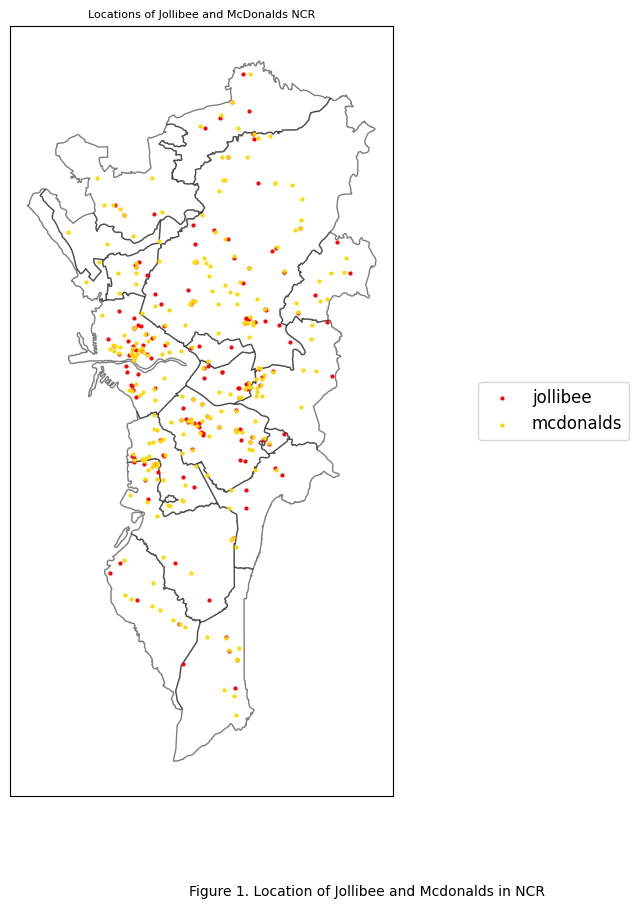

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
mm_outline.plot(ax=ax, color='white', edgecolor='black', alpha=0.5)
mcdo_points.plot(ax=ax, color='red', markersize=4, label='jollibee')
jollibee_points.plot(ax=ax, color='#FFD700', markersize=4, label='mcdonalds')
ax.set_yticks([])
ax.set_xticks([])
ax.legend(fontsize=12, loc='center left', bbox_to_anchor=(1.2, 0.5))
ax.set_title('Locations of Jollibee and McDonalds NCR', fontsize=8)
display(Markdown('## The locations of the Jollibee and Mcdonalds Establishments'))
fig.text(0.5, 0.01, "Figure 1. Location of Jollibee and Mcdonalds in NCR")
fig.show()

In [13]:
df_tally = within_metro_manila[
    (
        within_metro_manila['name'].str.contains('mcdonald', case=False) 
         | within_metro_manila['name'].str.contains('jollibee', case=False)
    ) & within_metro_manila['name'].notna()
]

In [14]:
df_tally['label'] = df_tally['name'].apply(lambda x: 'jollibee' if 'jollibee' in x.lower() else ('mcdonalds' if 'mcdonald' in x.lower() else ''))

In [15]:
dummy_df = pd.get_dummies(df_tally['label'], prefix='label', dtype=int)
df_tally = pd.concat([df_tally, dummy_df], axis=1)

In [16]:
choro_df1 = df_tally[['name_2', 'label_jollibee', 'label_mcdonalds']].groupby('name_2').sum()

In [17]:
choro_df2 = within_metro_manila[
    (
        within_metro_manila['name'].str.contains('mcdonald', case=False) 
         | within_metro_manila['name'].str.contains('jollibee', case=False)
    ) & within_metro_manila['name'].notna()
].dissolve(by='name_2')['geom'].to_frame()

In [18]:
choro_df = pd.concat([choro_df1, choro_df2], axis=1)
choro_df['winner'] = choro_df.apply(lambda row: 'mcdo' if row['label_mcdonalds'] > row['label_jollibee'] else ('jollibee' if row['label_jollibee'] > row['label_mcdonalds'] else 'tie'), axis=1)

In [19]:
choro_df

,label_jollibee,label_mcdonalds,geom,winner
name_2,,,,
Kalookan City,11,9,"MULTIPOLYGON (((120.97117 14.63454, 120.97037 ...",jollibee
Las Pinas,9,4,"MULTIPOLYGON (((120.97221 14.44048, 120.97216 ...",jollibee
Makati City,30,24,"POLYGON ((121.02389 14.53347, 121.02373 14.533...",jollibee
Malabon,3,0,"POLYGON ((120.95271 14.65276, 120.95240 14.652...",jollibee
Mandaluyong,8,11,"POLYGON ((121.03485 14.56866, 121.03412 14.568...",mcdo
Manila,37,30,"POLYGON ((120.97083 14.58083, 120.96979 14.579...",jollibee
Marikina,8,4,"POLYGON ((121.10265 14.62983, 121.10265 14.629...",jollibee
Muntinlupa,9,5,"POLYGON ((121.00920 14.36894, 121.00921 14.369...",jollibee
Navotas,2,0,"POLYGON ((120.94739 14.65340, 120.94756 14.653...",jollibee


In [20]:
choro_df = gpd.GeoDataFrame(choro_df, geometry='geom')

In [21]:
color_dict = {
    'jollibee': 'red',
    'mcdo': '#FFD700',
}

## The preference between the two

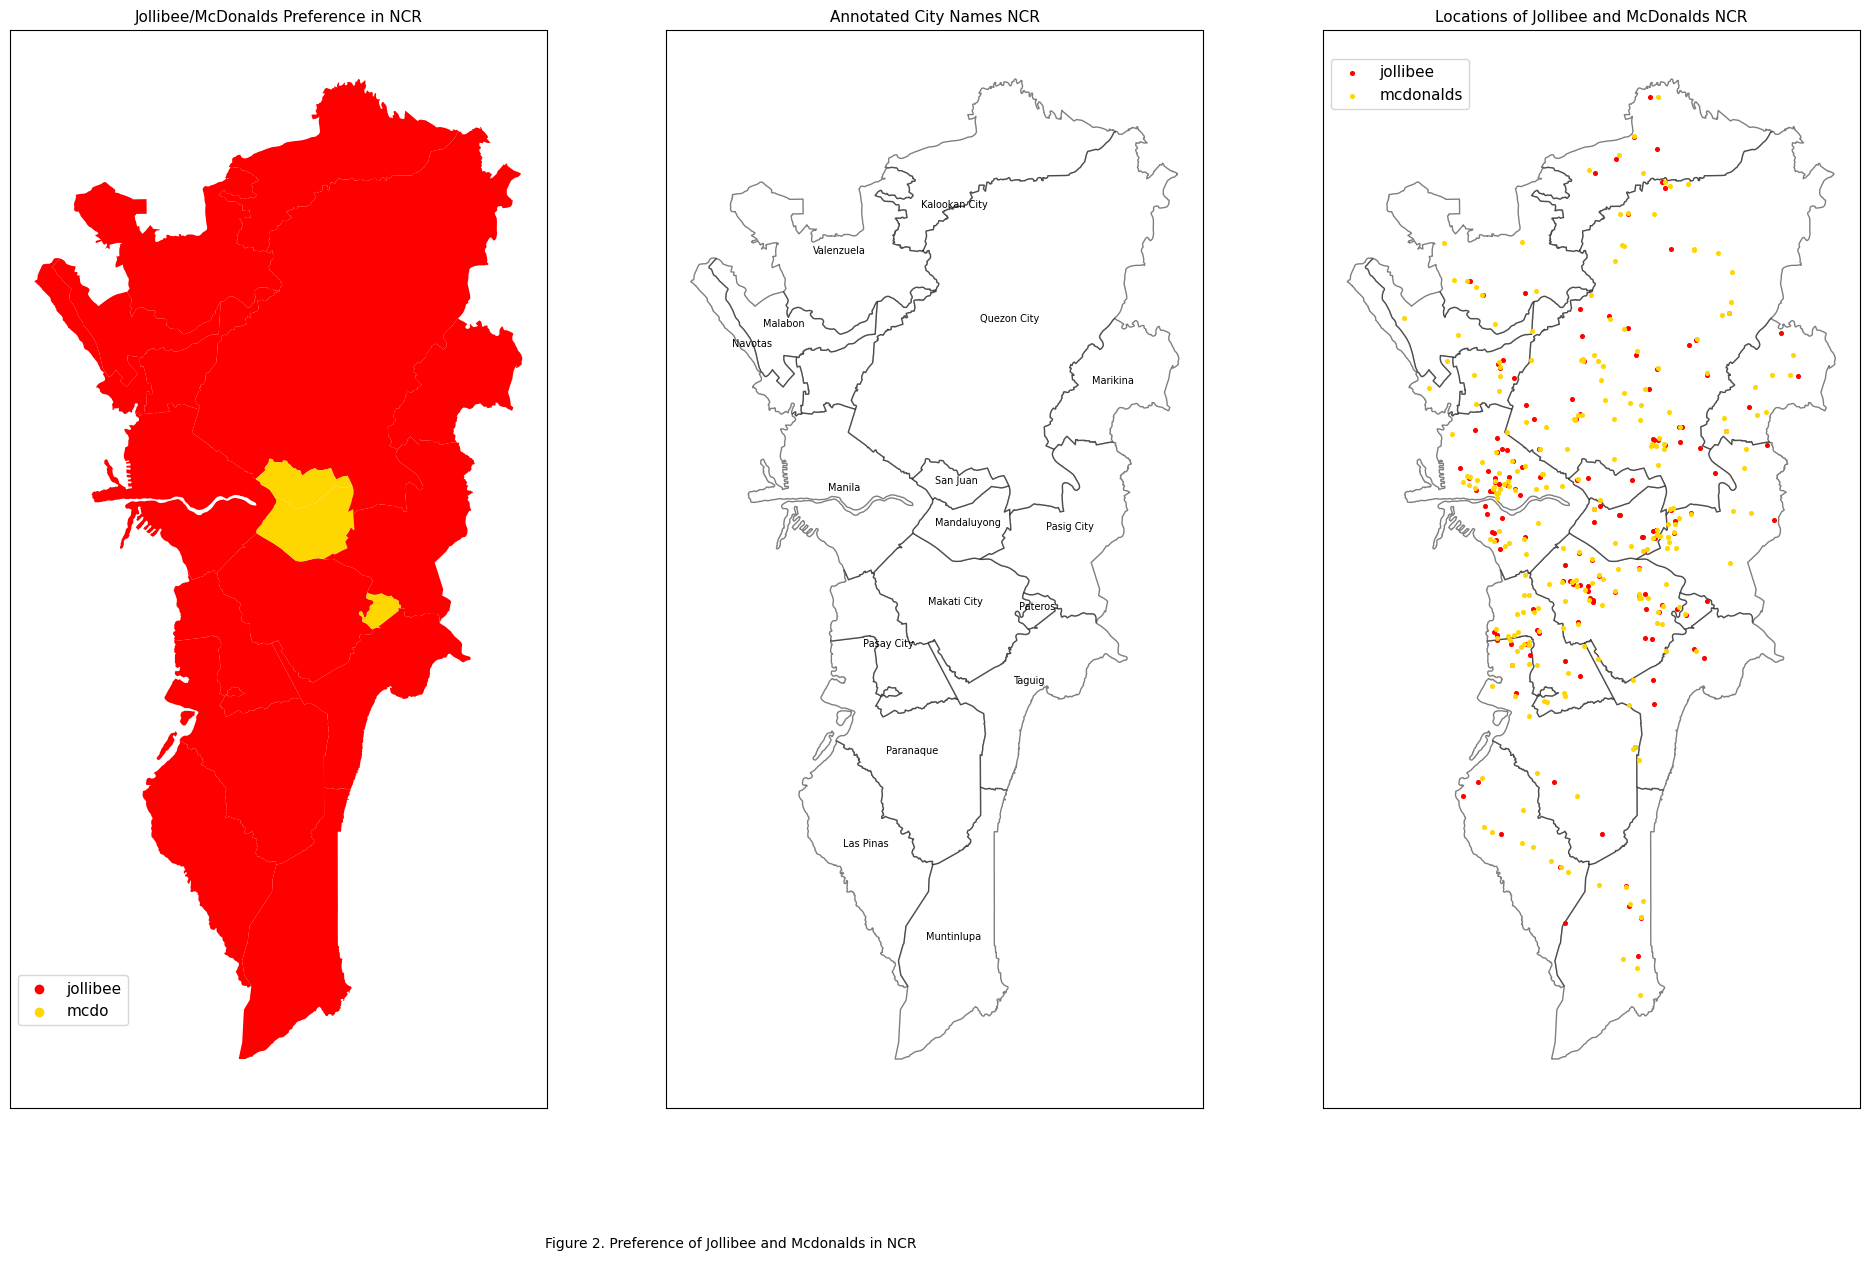

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(24, 14))


choro_df.plot(ax=ax[0], column="winner", legend=False, cmap=colors.ListedColormap(list(color_dict.values())))
ax[0].set_yticks([])
ax[0].set_xticks([])
for category, color in color_dict.items():
    ax[0].scatter([], [], c=color, label=category)
ax[0].legend(loc='center left', bbox_to_anchor=(0, 0.1), fontsize=11)
ax[0].set_title('Jollibee/McDonalds Preference in NCR', fontsize=11)

mm_outline.plot(ax=ax[1], color='white', edgecolor='black', alpha=0.5)
mm_outline.apply(
    lambda x: ax[1].annotate(text=x['name_2'], xy=x.geom.centroid.coords[0], ha='center', fontsize=7), axis=1
)
ax[1].set_yticks([])
ax[1].set_xticks([])
ax[1].set_title('Annotated City Names NCR', fontsize=11)

mm_outline.plot(ax=ax[2], color='white', edgecolor='black', alpha=0.5)
mcdo_points.plot(ax=ax[2], color='red', markersize=7, label='jollibee')
jollibee_points.plot(ax=ax[2], color='#FFD700', markersize=7, label='mcdonalds')
ax[2].set_yticks([])
ax[2].set_xticks([])
ax[2].legend(fontsize=11, loc='center left', bbox_to_anchor=(0, 0.95))
ax[2].set_title('Locations of Jollibee and McDonalds NCR', fontsize=11)

display(Markdown('## The preference between the two'))
fig.text(0.35, 0.01, "Figure 2. Preference of Jollibee and Mcdonalds in NCR")
fig.show()

## Done!